In [849]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
# Import label encoder 
from sklearn import preprocessing 

import os

# hide warnings
import warnings
warnings.filterwarnings('ignore')

In [850]:
#Reading the dataframe
train = pd.read_csv("./train.csv")

In [851]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [852]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [853]:
round(train.isnull().sum()/len(train.index)*100,2).sort_values(ascending=False).head(10)
#Remove features which are having more than 30% NUll values

PoolQC          99.52
MiscFeature     96.30
Alley           93.77
Fence           80.75
FireplaceQu     47.26
LotFrontage     17.74
GarageCond       5.55
GarageType       5.55
GarageYrBlt      5.55
GarageFinish     5.55
dtype: float64

In [854]:
train['Fence'].isnull().sum()

1179

In [855]:
#If Fireplace is not there then FireplaceQu is Null, correcting this
train.loc[(train.Fireplaces == 0),['FireplaceQu']] = 'NA'

round(train['FireplaceQu'].isnull().sum()/len(train.index)*100,2)

0.0

In [856]:
round(train.isnull().sum()/len(train.index)*100,2).sort_values(ascending=False).head(10)

PoolQC          99.52
MiscFeature     96.30
Alley           93.77
Fence           80.75
LotFrontage     17.74
GarageQual       5.55
GarageCond       5.55
GarageYrBlt      5.55
GarageType       5.55
GarageFinish     5.55
dtype: float64

In [857]:
#Deleting 4 features having very high Null values and do not hold much business value
train  = train.loc[:,round(train.isnull().sum()/len(train.index)*100,2) < 30]

In [858]:
round(train.isnull().sum()/len(train.index)*100,2).sort_values(ascending=False).head(10)

LotFrontage     17.74
GarageFinish     5.55
GarageType       5.55
GarageCond       5.55
GarageQual       5.55
GarageYrBlt      5.55
BsmtExposure     2.60
BsmtFinType2     2.60
BsmtFinType1     2.53
BsmtCond         2.53
dtype: float64

In [859]:
(train.isnull().sum()).sort_values(ascending=False).head(10)

LotFrontage     259
GarageFinish     81
GarageType       81
GarageCond       81
GarageQual       81
GarageYrBlt      81
BsmtExposure     38
BsmtFinType2     38
BsmtFinType1     37
BsmtCond         37
dtype: int64

In [860]:
#LotFrontage is almost 18% Null values
train[['LotFrontage','LotArea']].describe()

,LotFrontage,LotArea
count,1201.000000,1460.000000
mean,70.049958,10516.828082
std,24.284752,9981.264932
min,21.000000,1300.000000
25%,59.000000,7553.500000
50%,69.000000,9478.500000
75%,80.000000,11601.500000
max,313.000000,215245.000000


In [861]:
#IR1 shape Null % is higher
train.loc[train.LotFrontage.isnull(),['LotShape']].groupby('LotShape')['LotShape'].count()

LotShape
IR1    167
IR2     15
IR3      3
Reg     74
Name: LotShape, dtype: int64

In [862]:
train.groupby('LotShape')['LotShape'].count()
#In overall data Reg shape is more

LotShape
IR1    484
IR2     41
IR3     10
Reg    925
Name: LotShape, dtype: int64

In [863]:
#Finding out mean value for every shape type and this will be used to impute Null values
df = train.groupby('LotShape')['LotArea'].mean()
df


LotShape
IR1    11894.545455
IR2    23733.658537
IR3    41338.200000
Reg     8876.915676
Name: LotArea, dtype: float64

In [864]:

train.loc[((train.LotShape == 'Reg') & (train.LotFrontage.isnull())),['LotFrontage']] = df.Reg
train.loc[((train.LotShape == 'IR1') & (train.LotFrontage.isnull())),['LotFrontage']] = df.IR1
train.loc[((train.LotShape == 'IR2') & (train.LotFrontage.isnull())),['LotFrontage']] = df.IR2
train.loc[((train.LotShape == 'IR3') & (train.LotFrontage.isnull())),['LotFrontage']] = df.IR3

train.LotFrontage.isnull().sum()

#LotFrontage is handled now

0

In [865]:
#Checking for Target variable now
train['SalePrice'].describe()
#Few records are having way high SalePrice, deleting values more than 0.99 percentile

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

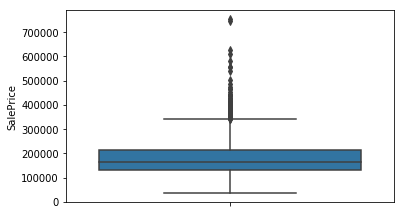

In [866]:
plt.figure(figsize=(20, 12))
plt.subplot(3,3,1)
sns.boxplot(y = 'SalePrice', data = train)
plt.show()

In [867]:
train.loc[train.SalePrice > train.SalePrice.quantile(.99)]
#Deleting the outliers above 0.99 percentile, deleting 15 records

train = train.loc[train.SalePrice < train.SalePrice.quantile(.99)]

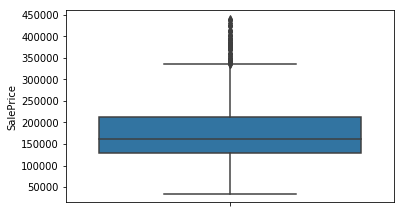

In [868]:
plt.figure(figsize=(20, 12))
plt.subplot(3,3,1)
sns.boxplot(y = 'SalePrice', data = train)
plt.show()

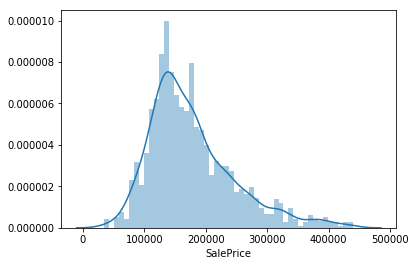

In [869]:
sns.distplot(train['SalePrice'], bins=50)
#SalePrice is skewed thus checking with log(SalePrice)

In [870]:
train['LogSalePrice'] = np.log(train['SalePrice'])

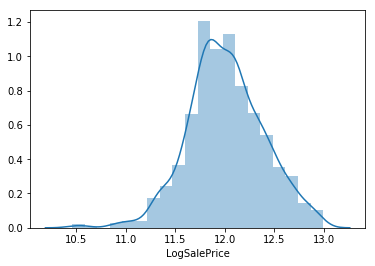

In [871]:
sns.distplot(train['LogSalePrice'], bins=20)
#This looks more normal distribution, going ahead with this derived feature.. column deletion will happen later

In [872]:
#Checking further for Null values
round(train.isnull().sum()/len(train.index)*100,2).sort_values(ascending=False).head(20)

GarageType      5.61
GarageYrBlt     5.61
GarageFinish    5.61
GarageQual      5.61
GarageCond      5.61
BsmtFinType2    2.63
BsmtExposure    2.63
BsmtFinType1    2.56
BsmtCond        2.56
BsmtQual        2.56
MasVnrType      0.48
MasVnrArea      0.48
Electrical      0.07
YearBuilt       0.00
Exterior2nd     0.00
ExterQual       0.00
ExterCond       0.00
Exterior1st     0.00
RoofMatl        0.00
Foundation      0.00
dtype: float64

In [873]:
#GarageCars,GarageArea should be enough for information on garage, other garage paramters are not important, deleting those columns

columnsToBeDeleted = ['GarageType','GarageYrBlt','GarageFinish','GarageQual','GarageCond']

train.drop(columnsToBeDeleted, axis=1, inplace=True)

In [874]:
(train.isnull().sum()).sort_values(ascending=False).head(20)

BsmtFinType2    38
BsmtExposure    38
BsmtFinType1    37
BsmtCond        37
BsmtQual        37
MasVnrType       7
MasVnrArea       7
Electrical       1
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
ExterCond        0
ExterQual        0
YearBuilt        0
Foundation       0
BsmtFinSF1       0
YearRemodAdd     0
LogSalePrice     0
BsmtFinSF2       0
dtype: int64

In [875]:
#BsmtFinType2 --> do not look important after checking the feature details, will be deleted

train.loc[train.BsmtFinType1.isnull(),['BsmtFinSF1']]
#Thus if BsmtFinSF1 is zero then BsmtFinType1 is Null - marking that as NA
train.BsmtFinType1.value_counts()

train.loc[(train.BsmtFinSF1 == 0),['BsmtFinType1']] = 'NA'
train.loc[(train.BsmtFinSF1 == 0),['BsmtExposure']] = 'NA'
train.loc[(train.BsmtFinSF1 == 0),['BsmtCond']] = 'NA'
train.loc[(train.BsmtFinSF1 == 0),['BsmtQual']] = 'NA'

(train.isnull().sum()).sort_values(ascending=False).head()



BsmtFinType2    38
MasVnrType       7
MasVnrArea       7
Electrical       1
ExterQual        0
dtype: int64

In [876]:
#Imputing for 6 records
train.loc[train.MasVnrType.isnull(),['MasVnrType','MasVnrArea']] = ['None',0]
(train.isnull().sum()).sort_values(ascending=False).head()

BsmtFinType2    38
Electrical       1
ExterQual        0
RoofStyle        0
RoofMatl         0
dtype: int64

In [877]:
train.Electrical.value_counts()
train.Electrical.isnull().sum()

#only 1 value is Null, imputing with most probable value
train.loc[train.Electrical.isnull(), 'Electrical'] = "SBrkr"

In [878]:
train.Electrical.value_counts()
train.Electrical.isnull().sum()
(train.isnull().sum()).sort_values(ascending=False).head()

BsmtFinType2    38
BsmtFinSF2       0
YearRemodAdd     0
RoofStyle        0
RoofMatl         0
dtype: int64

Null values are handled, will check more later on
Continuing with EDA and deciding on feature deletion also if not much varaince is covered by the feature

In [879]:
train.BsmtExposure.value_counts()

No    607
NA    464
Av    172
Gd    115
Mn     87
Name: BsmtExposure, dtype: int64

In [880]:
train.MSSubClass.value_counts()*100/len(train.index)

20     36.747405
60     20.069204
50      9.965398
120     6.020761
30      4.775087
160     4.359862
70      4.152249
80      4.013841
90      3.598616
190     2.076125
85      1.384083
75      1.038062
45      0.830450
180     0.692042
40      0.276817
Name: MSSubClass, dtype: float64

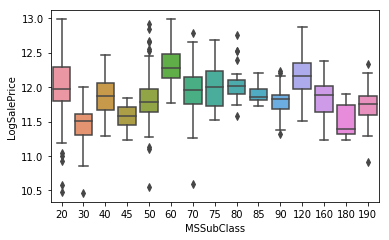

In [881]:
plt.figure(figsize=(20, 12))
plt.subplot(3,3,1)
sns.boxplot(x = 'MSSubClass', y = 'LogSalePrice', data = train)
plt.show()
#All distributed, not a specific pattern

In [882]:
#Clubbing lower % values
def MSSubClass(str):
    #print(str)
    if (str == 20):
        return "1StryNewer"
    elif (str == 60):
        return "2StryNewer"
    elif (str == 50):
        return "1_15StryAllAges"
    elif (str == 120):
        return "1StryPUD"
    else:
        return "Others"
    
train.MSSubClass = train.MSSubClass.apply(MSSubClass)
train.MSSubClass.value_counts()

1StryNewer         531
Others             393
2StryNewer         290
1_15StryAllAges    144
1StryPUD            87
Name: MSSubClass, dtype: int64

In [883]:
#Grouping lower % values
train.MSZoning.value_counts()*100/len(train.index)
train['MSZoning'] = train['MSZoning'].apply(lambda x : "Others" if ((x == 'FV') or (x== 'RH') or (x == "C (all)") )else x)

train.MSZoning.value_counts()*100/len(train.index)

RL        78.685121
RM        15.017301
Others     6.297578
Name: MSZoning, dtype: float64

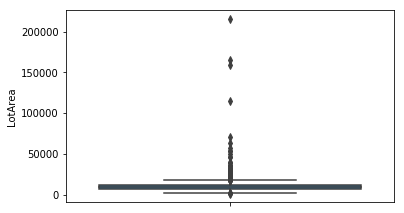

In [884]:
plt.figure(figsize=(20, 12))
plt.subplot(3,3,1)
sns.boxplot(y = 'LotArea', data = train)
plt.show()
#LotArea - Extreme high plot sizes are there and will skew our model, deleting >0.99 percentile records

In [885]:
train.LotArea.describe()

count      1445.000000
mean      10423.696886
std        9929.978538
min        1300.000000
25%        7500.000000
50%        9430.000000
75%       11478.000000
max      215245.000000
Name: LotArea, dtype: float64

In [886]:
train[train.LotArea > train.LotArea.quantile(0.99)]['LotArea']
#There are extreme outliers, skewing the data, removing those few cases which are more than 0.99 percentile
train = train[train.LotArea < train.LotArea.quantile(0.99)]

In [887]:
train.LotArea.describe()

count     1430.000000
mean      9686.606993
std       4095.444118
min       1300.000000
25%       7500.000000
50%       9375.000000
75%      11407.750000
max      35133.000000
Name: LotArea, dtype: float64

In [888]:
train.Street.value_counts()*100/len(train.index)
#To delete, no variance

Pave    99.65035
Grvl     0.34965
Name: Street, dtype: float64

In [889]:
train.LotShape.value_counts()*100/len(train.index)


Reg    64.335664
IR1    32.727273
IR2     2.377622
IR3     0.559441
Name: LotShape, dtype: float64

In [890]:
train.LandContour.value_counts()*100/len(train.index)
#Almost 90% LvL, To delete, no variance

Lvl    90.629371
Bnk     4.125874
HLS     3.356643
Low     1.888112
Name: LandContour, dtype: float64

In [891]:
train.Utilities.value_counts()*100/len(train.index)
#To delete, no variance

AllPub    99.93007
NoSeWa     0.06993
Name: Utilities, dtype: float64

In [892]:
#LotConfig
train.LotConfig.value_counts()*100/len(train.index)
train['LotConfig'] = train['LotConfig'].apply(lambda x : "Others" if ((x == 'CulDSac') or (x== 'FR2') or (x == "FR3") )else x)
train.LotConfig.value_counts()*100/len(train.index)

Inside    72.447552
Corner    17.972028
Others     9.580420
Name: LotConfig, dtype: float64

In [893]:
train.LandSlope.value_counts()*100/len(train.index)
#To delete, no variance - 94% Gtl type

Gtl    95.314685
Mod     4.195804
Sev     0.489510
Name: LandSlope, dtype: float64

In [894]:

train.Neighborhood.value_counts()*100/len(train.index)

#Not doing anything as grouping also does not look possible, this is all distributed

NAmes      15.734266
CollgCr    10.489510
OldTown     7.832168
Edwards     6.853147
Somerst     6.013986
Gilbert     5.524476
Sawyer      5.174825
NWAmes      5.104895
NridgHt     4.895105
SawyerW     4.125874
BrkSide     4.055944
Crawfor     3.566434
Mitchel     3.426573
IDOTRR      2.587413
NoRidge     2.517483
Timber      2.447552
SWISU       1.748252
StoneBr     1.538462
ClearCr     1.398601
Blmngtn     1.188811
MeadowV     1.188811
BrDale      1.118881
Veenker     0.699301
NPkVill     0.629371
Blueste     0.139860
Name: Neighborhood, dtype: float64

In [895]:
train.Condition1.value_counts()*100/len(train.index)
train['Condition1'] = train['Condition1'].apply(lambda x : x if ((x == 'Norm') or (x== 'Feedr') or (x == "Artery") )else "Others")
train.Condition1.value_counts()*100/len(train.index)

Norm      86.293706
Feedr      5.524476
Others     4.895105
Artery     3.286713
Name: Condition1, dtype: float64

In [896]:
train.BldgType.value_counts()*100/len(train.index)
train['BldgType'] = train['BldgType'].apply(lambda x : x if ((x == '1Fam') or (x== 'TwnhsE') or (x == "Duplex") )else "Others")
train.BldgType.value_counts()*100/len(train.index)

1Fam      83.286713
TwnhsE     7.972028
Others     5.104895
Duplex     3.636364
Name: BldgType, dtype: float64

In [897]:

train.HouseStyle.value_counts()*100/len(train.index)
train['HouseStyle'] = train['HouseStyle'].apply(lambda x : x if ((x == '1Story') or (x== '2Story') or (x == "1.5Fin") )else "Others")
train.HouseStyle.value_counts()*100/len(train.index)

1Story    49.860140
2Story    30.209790
1.5Fin    10.559441
Others     9.370629
Name: HouseStyle, dtype: float64

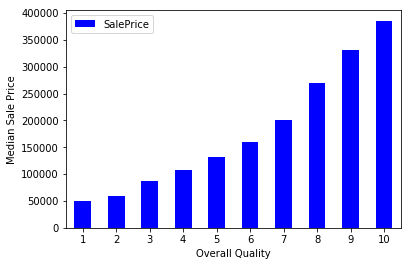

In [898]:
quality_pivot = train.pivot_table(index='OverallQual', values='SalePrice', aggfunc=np.median)
quality_pivot.plot(kind='bar', color='blue')
plt.xlabel('Overall Quality')
plt.ylabel('Median Sale Price')
plt.xticks(rotation=0)
plt.show()

#High correlation - high Quality - high price

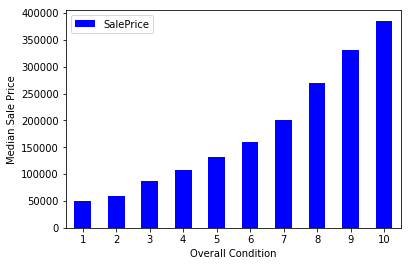

In [899]:
condition_pivot = train.pivot_table(index='OverallCond', values='SalePrice', aggfunc=np.median)
quality_pivot.plot(kind='bar', color='blue')
plt.xlabel('Overall Condition')
plt.ylabel('Median Sale Price')
plt.xticks(rotation=0)
plt.show()

#High correlation - Excellent Condition - high price

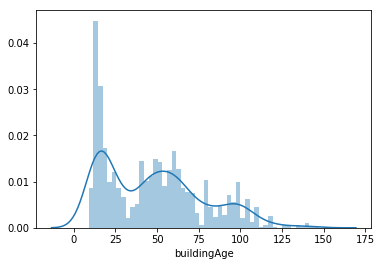

In [900]:
#Finding out Age of the property and this derived feature will be used further
train.YearBuilt.unique()

train['buildingAge'] = 2019-train.YearBuilt

sns.distplot(train['buildingAge'], bins=50)


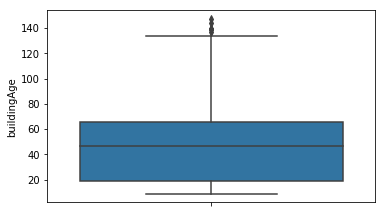

In [901]:
plt.figure(figsize=(20, 12))
plt.subplot(3,3,1)
sns.boxplot(y = 'buildingAge', data = train)
plt.show()

In [902]:
train.buildingAge.describe()
train.loc[train.buildingAge > train.buildingAge.quantile(.99)]['buildingAge'].count()
#Deleting the outliers above 0.99 percentile, deleting 15 records

train = train.loc[train.buildingAge < train.buildingAge.quantile(.99)]
train.buildingAge.describe()

count    1406.000000
mean       46.613087
std        28.500253
min         9.000000
25%        19.000000
50%        46.000000
75%        65.000000
max       115.000000
Name: buildingAge, dtype: float64

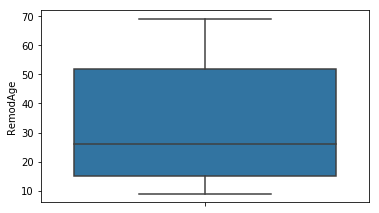

In [903]:
#Repeating above process for YearRemodAdd, finding out when the propery was last remodelled
train.loc[train.YearRemodAdd != train.YearBuilt,['YearBuilt','YearRemodAdd']]

#Creating the same bins for YearRemodAdd

train['RemodAge'] = 2019-train.YearRemodAdd

#sns.distplot(train['RemodAge'], bins=50)

#Now columns YearRemodAdd, RemodAge can be dropped

plt.figure(figsize=(20, 12))
plt.subplot(3,3,1)
sns.boxplot(y = 'RemodAge', data = train)
plt.show()

In [904]:
train.RoofMatl.value_counts()*100/len(train.index)
#98% CompShg - no variance, feature being deleted

CompShg    98.648649
Tar&Grv     0.711238
WdShake     0.355619
WdShngl     0.142248
Metal       0.071124
Roll        0.071124
Name: RoofMatl, dtype: float64

In [905]:

train.Exterior1st.value_counts()*100/len(train.index)

train['Exterior1st'] = train['Exterior1st'].apply(lambda x : x if ((x == 'VinylSd') or (x== 'HdBoard') or (x == "MetalSd") or (x == 'Wd Sdng') )else "Others")
train.Exterior1st.value_counts()*100/len(train.index)

#Exterior2nd will be deleted

VinylSd    35.633001
Others     19.985775
HdBoard    15.504979
MetalSd    15.291607
Wd Sdng    13.584637
Name: Exterior1st, dtype: float64

In [906]:
train.MasVnrType.value_counts()*100/len(train.index)
#Deleting MasVnrArea, MasVnrType - Not much meaningfull variation

None       59.459459
BrkFace    31.294452
Stone       8.321479
BrkCmn      0.924609
Name: MasVnrType, dtype: float64

In [907]:
train.ExterQual.value_counts()*100/len(train.index)

TA    62.304410
Gd    33.997155
Ex     2.702703
Fa     0.995733
Name: ExterQual, dtype: float64

In [908]:
train.Foundation.value_counts()*100/len(train.index)
train['Foundation'] = train['Foundation'].apply(lambda x : x if ((x == 'PConc') or (x== 'CBlock') or (x == "BrkTil") )else "Others")
train.Foundation.value_counts()*100/len(train.index)

PConc     44.594595
CBlock    44.096728
BrkTil     9.174964
Others     2.133713
Name: Foundation, dtype: float64

In [909]:
train.BsmtQual.value_counts()*100/len(train.index)

TA    32.574680
NA    31.721195
Gd    29.943101
Ex     5.192034
Fa     0.568990
Name: BsmtQual, dtype: float64

In [910]:
train.BsmtCond.value_counts()*100/len(train.index)

TA    63.655761
NA    31.721195
Gd     3.271693
Fa     1.280228
Po     0.071124
Name: BsmtCond, dtype: float64

In [911]:
train.BsmtExposure.value_counts()*100/len(train.index)

No    42.674253
NA    31.721195
Av    12.019915
Gd     7.467994
Mn     6.116643
Name: BsmtExposure, dtype: float64

In [912]:
train.BsmtFinType1.value_counts()*100/len(train.index)

NA     31.721195
GLQ    28.520626
ALQ    15.291607
BLQ    10.170697
Rec     9.246088
LwQ     5.049787
Name: BsmtFinType1, dtype: float64

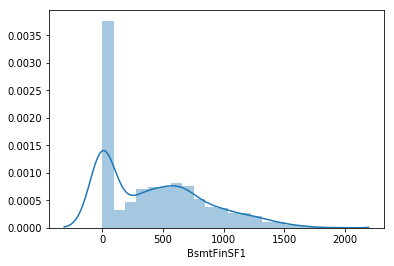

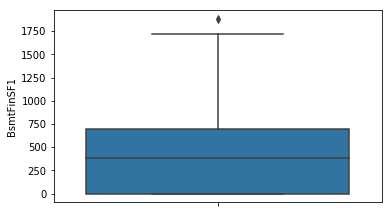

In [913]:
#train.BsmtFinSF1.value_counts()
sns.distplot(train['BsmtFinSF1'], bins=20)

plt.figure(figsize=(20, 12))
plt.subplot(3,3,1)
sns.boxplot(y = 'BsmtFinSF1', data = train)
plt.show()

#Around 31% are no basement cases
#BsmtFinType2, BsmtFinSF2, BsmtUnfSF will be dropped

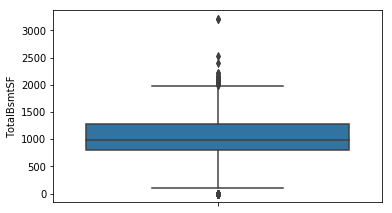

In [914]:

plt.figure(figsize=(20, 12))
plt.subplot(3,3,1)
sns.boxplot(y = 'TotalBsmtSF', data = train)
plt.show()

In [915]:

train.Heating.value_counts()*100/len(train.index)
#No variance, will be deleted
#HeatingQC will also be deleted

GasA     98.079659
GasW      0.995733
Grav      0.497866
Wall      0.284495
Floor     0.071124
OthW      0.071124
Name: Heating, dtype: float64

In [916]:

train.CentralAir.value_counts()*100/len(train.index)
#No variance, will be deleted

Y    93.954481
N     6.045519
Name: CentralAir, dtype: float64

In [917]:

train.Electrical.value_counts()*100/len(train.index)
#No variance, will be deleted

SBrkr    91.465149
FuseA     6.330014
FuseF     1.920341
FuseP     0.213371
Mix       0.071124
Name: Electrical, dtype: float64

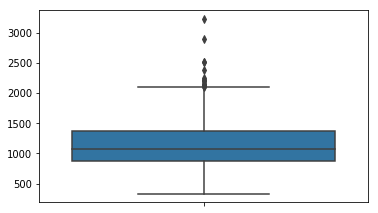

In [918]:
plt.figure(figsize=(20, 12))
plt.subplot(3,3,1)
sns.boxplot(y = ['1stFlrSF'], data = train)
plt.show()

In [919]:
train.BsmtFullBath.value_counts()*100/len(train.index)

0    58.890469
1    40.327169
2     0.711238
3     0.071124
Name: BsmtFullBath, dtype: float64

In [920]:
train.Functional.value_counts()*100/len(train.index)
#Will be deleted, 93% Typ type, less variance

Typ     93.456615
Min2     2.204836
Min1     2.062589
Maj1     0.995733
Mod      0.853485
Maj2     0.355619
Sev      0.071124
Name: Functional, dtype: float64

In [921]:
train.GarageCars.value_counts()*100/len(train.index)

2    57.041252
1    25.746799
3    11.450925
0     5.476529
4     0.284495
Name: GarageCars, dtype: float64

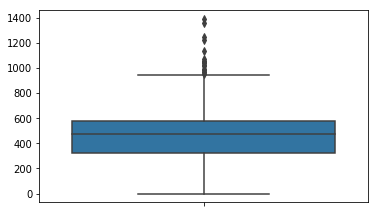

In [922]:
plt.figure(figsize=(20, 12))
plt.subplot(3,3,1)
sns.boxplot(y = ['GarageArea'], data = train)
plt.show()

In [923]:
train.PavedDrive.value_counts()*100/len(train.index)
#Will be deleted, 92% Y type, less variance

Y    92.674253
N     5.334282
P     1.991465
Name: PavedDrive, dtype: float64

In [924]:
#Categorical variables
dummyGen = ['MSSubClass','MSZoning','LotShape','LotConfig','Neighborhood','Condition1','BldgType','Foundation',
           'HouseStyle','RoofStyle','Exterior1st','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1', 'FireplaceQu']

In [925]:
#Columns being deleted as one type of value prevails
#Sale raleted features are deleted - no visible impact
ToBeDropped = ['Street','Utilities', 'LandContour','LandSlope','Condition2', 'YearBuilt','YearRemodAdd','RoofMatl','BsmtFinType2',
              'BsmtFinSF2','Heating','BsmtHalfBath','Functional', 'MiscVal','MoSold','YrSold','SaleType','SaleCondition',
               'CentralAir','Exterior2nd','MasVnrType','MasVnrArea','BsmtUnfSF','HeatingQC','Electrical','PavedDrive','LandSlope']

In [926]:
# label_encoder object knows how to understand word labels. 
#Encoding features where Hierarchical values are there
label_encoder = preprocessing.LabelEncoder() 
train['ExterQual'].unique() 

train['ExterQual']= label_encoder.fit_transform(train['ExterQual']) 
  
train['ExterQual'].unique() 

array([2, 3, 0, 1], dtype=int64)

In [927]:

print(train['KitchenQual'].value_counts())
train['KitchenQual']= label_encoder.fit_transform(train['KitchenQual']) 
  
train['KitchenQual'].unique() 

TA    712
Gd    573
Ex     83
Fa     38
Name: KitchenQual, dtype: int64


array([2, 3, 0, 1], dtype=int64)

In [928]:
print(train['ExterCond'].value_counts())
train['ExterCond']= label_encoder.fit_transform(train['ExterCond']) 
  
train['ExterCond'].unique() 

TA    1238
Gd     138
Fa      27
Ex       2
Po       1
Name: ExterCond, dtype: int64


array([4, 2, 1, 3, 0], dtype=int64)

In [929]:
print(train['ExterQual'].value_counts())
train['ExterQual']= label_encoder.fit_transform(train['ExterQual']) 
  
train['ExterQual'].unique() 

3    876
2    478
0     38
1     14
Name: ExterQual, dtype: int64


array([2, 3, 0, 1], dtype=int64)

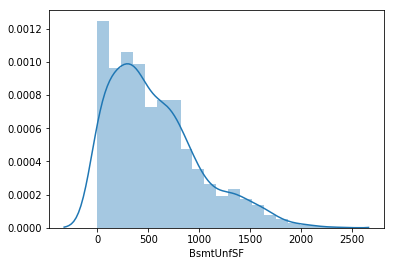

In [930]:
sns.distplot(train['BsmtUnfSF'], bins=20)

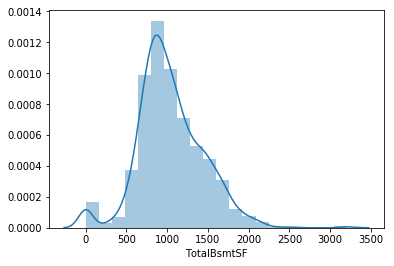

In [931]:
sns.distplot(train['TotalBsmtSF'], bins=20)

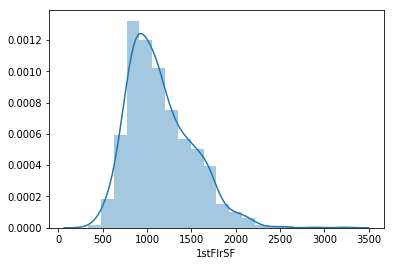

In [932]:
sns.distplot(train['1stFlrSF'], bins=20)

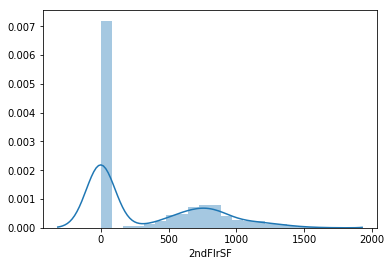

In [933]:
sns.distplot(train['2ndFlrSF'], bins=20)

count    1406.000000
mean        5.431010
std        46.776251
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       528.000000
Name: LowQualFinSF, dtype: float64

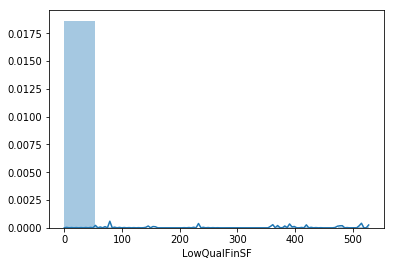

In [934]:
sns.distplot(train['LowQualFinSF'], bins=10)
train.LowQualFinSF.describe()

count    1406.00000
mean     1483.22404
std       475.34529
min       334.00000
25%      1121.25000
50%      1442.00000
75%      1739.75000
max      3447.00000
Name: GrLivArea, dtype: float64

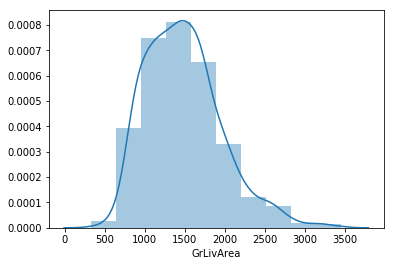

In [935]:

sns.distplot(train['GrLivArea'], bins=10)
train.GrLivArea.describe()

count    1406.000000
mean        0.598862
std         0.631193
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         3.000000
Name: Fireplaces, dtype: float64

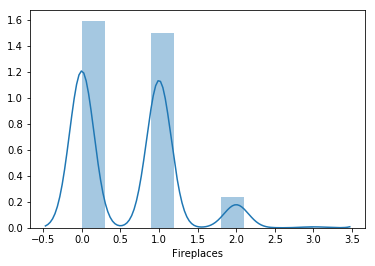

In [936]:

sns.distplot(train['Fireplaces'], bins=10)
train.Fireplaces.describe()

count    1406.000000
mean       91.793030
std       121.334128
min         0.000000
25%         0.000000
50%         0.000000
75%       168.000000
max       736.000000
Name: WoodDeckSF, dtype: float64

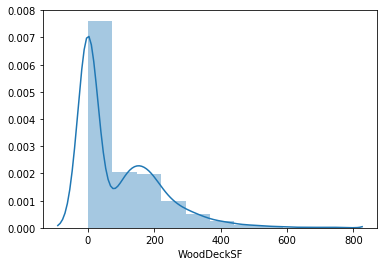

In [937]:

sns.distplot(train['WoodDeckSF'], bins=10)
train.WoodDeckSF.describe()

In [938]:
train.drop(ToBeDropped, axis=1, inplace=True)
#Features are deleted which are not too relevant

In [939]:
train.isnull().values.any()
#No Null values now

False

In [940]:
train.columns[train.isna().any()].tolist()

[]

In [941]:
train.info()
#We are left with 49 features and 1459 records
#53 records are deleted which were mainly outlier cases

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1406 entries, 0 to 1459
Data columns (total 49 columns):
Id               1406 non-null int64
MSSubClass       1406 non-null object
MSZoning         1406 non-null object
LotFrontage      1406 non-null float64
LotArea          1406 non-null int64
LotShape         1406 non-null object
LotConfig        1406 non-null object
Neighborhood     1406 non-null object
Condition1       1406 non-null object
BldgType         1406 non-null object
HouseStyle       1406 non-null object
OverallQual      1406 non-null int64
OverallCond      1406 non-null int64
RoofStyle        1406 non-null object
Exterior1st      1406 non-null object
ExterQual        1406 non-null int64
ExterCond        1406 non-null int32
Foundation       1406 non-null object
BsmtQual         1406 non-null object
BsmtCond         1406 non-null object
BsmtExposure     1406 non-null object
BsmtFinType1     1406 non-null object
BsmtFinSF1       1406 non-null int64
TotalBsmtSF      1406 non

In [942]:
# all numeric (float and int) variables in the dataset
train_numeric = train.select_dtypes(include=['float64', 'int64'])
train_numeric.columns

Index(['Id', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'ExterQual', 'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'SalePrice',
       'LogSalePrice', 'buildingAge', 'RemodAge'],
      dtype='object')

In [943]:
#These 3 columns are encoded
train_numeric.drop(['OverallQual','OverallCond','ExterQual'],axis=1, inplace=True)
train_numeric.columns

Index(['Id', 'LotFrontage', 'LotArea', 'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'SalePrice',
       'LogSalePrice', 'buildingAge', 'RemodAge'],
      dtype='object')

In [944]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1406 entries, 0 to 1459
Data columns (total 49 columns):
Id               1406 non-null int64
MSSubClass       1406 non-null object
MSZoning         1406 non-null object
LotFrontage      1406 non-null float64
LotArea          1406 non-null int64
LotShape         1406 non-null object
LotConfig        1406 non-null object
Neighborhood     1406 non-null object
Condition1       1406 non-null object
BldgType         1406 non-null object
HouseStyle       1406 non-null object
OverallQual      1406 non-null int64
OverallCond      1406 non-null int64
RoofStyle        1406 non-null object
Exterior1st      1406 non-null object
ExterQual        1406 non-null int64
ExterCond        1406 non-null int32
Foundation       1406 non-null object
BsmtQual         1406 non-null object
BsmtCond         1406 non-null object
BsmtExposure     1406 non-null object
BsmtFinType1     1406 non-null object
BsmtFinSF1       1406 non-null int64
TotalBsmtSF      1406 non

In [945]:
plt.figure(figsize=(20, 10))
#sns.pairplot(train_numeric)
#plt.show()
#Pairplot and Heatmap can be checked here, but file takes too long to run as number of features are too high

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

In [946]:
plt.figure(figsize = (20, 16))
#sns.heatmap(train_numeric.corr(), annot = True, cmap="YlGnBu")
#plt.show()

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

In [947]:
#DF is clean now, go ahead with dummy variable generation

# Creating a dummy variable for some of the categorical variables and dropping the first one.
dummy1 = pd.get_dummies(train[dummyGen], drop_first=True)

# Adding the results to the master dataframe

train = pd.concat([train, dummy1], axis=1)

In [948]:
train.drop(dummyGen, axis=1, inplace=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1406 entries, 0 to 1459
Columns: 111 entries, Id to FireplaceQu_TA
dtypes: float64(2), int32(2), int64(29), uint8(78)
memory usage: 469.6 KB


In [949]:
train.head()

,Id,LotFrontage,LotArea,OverallQual,OverallCond,ExterQual,ExterCond,BsmtFinSF1,TotalBsmtSF,1stFlrSF,...,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_NA,BsmtFinType1_Rec,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_NA,FireplaceQu_Po,FireplaceQu_TA
0,1,65.0,8450,7,5,2,4,706,856,856,...,0,1,0,0,0,0,0,1,0,0
1,2,80.0,9600,6,8,3,4,978,1262,1262,...,0,0,0,0,0,0,0,0,0,1
2,3,68.0,11250,7,5,2,4,486,920,920,...,0,1,0,0,0,0,0,0,0,1
3,4,60.0,9550,7,5,3,4,216,756,961,...,0,0,0,0,0,0,1,0,0,0
4,5,84.0,14260,8,5,2,4,655,1145,1145,...,0,1,0,0,0,0,0,0,0,1


In [950]:
#x & y split
y = train['LogSalePrice']

#Dropping id and SalePrice from train
train.drop(['Id', 'LogSalePrice','SalePrice'], axis=1, inplace=True)

X = train

In [951]:
train.head()

,LotFrontage,LotArea,OverallQual,OverallCond,ExterQual,ExterCond,BsmtFinSF1,TotalBsmtSF,1stFlrSF,2ndFlrSF,...,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_NA,BsmtFinType1_Rec,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_NA,FireplaceQu_Po,FireplaceQu_TA
0,65.0,8450,7,5,2,4,706,856,856,854,...,0,1,0,0,0,0,0,1,0,0
1,80.0,9600,6,8,3,4,978,1262,1262,0,...,0,0,0,0,0,0,0,0,0,1
2,68.0,11250,7,5,2,4,486,920,920,866,...,0,1,0,0,0,0,0,0,0,1
3,60.0,9550,7,5,3,4,216,756,961,756,...,0,0,0,0,0,0,1,0,0,0
4,84.0,14260,8,5,2,4,655,1145,1145,1053,...,0,1,0,0,0,0,0,0,0,1


In [952]:
# scaling the features
from sklearn.preprocessing import scale

# storing column names in cols, since column names are (annoyingly) lost after 
# scaling (the df is converted to a numpy array)
cols = X.columns
X = pd.DataFrame(scale(X))
X.columns = cols
X.columns

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'ExterQual',
       'ExterCond', 'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       ...
       'BsmtFinType1_BLQ', 'BsmtFinType1_GLQ', 'BsmtFinType1_LwQ',
       'BsmtFinType1_NA', 'BsmtFinType1_Rec', 'FireplaceQu_Fa',
       'FireplaceQu_Gd', 'FireplaceQu_NA', 'FireplaceQu_Po', 'FireplaceQu_TA'],
      dtype='object', length=108)

In [953]:
X.columns[:6]

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'ExterQual',
       'ExterCond'],
      dtype='object')

In [954]:
X.head()

,LotFrontage,LotArea,OverallQual,OverallCond,ExterQual,ExterCond,BsmtFinSF1,TotalBsmtSF,1stFlrSF,2ndFlrSF,...,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_NA,BsmtFinType1_Rec,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_NA,FireplaceQu_Po,FireplaceQu_TA
0,-0.431787,-0.299443,0.701239,-0.516627,-0.853916,0.360593,0.656290,-0.462721,-0.802205,1.232503,...,-0.336485,1.583109,-0.230616,-0.681604,-0.319188,-0.15261,-0.584468,1.046604,-0.117041,-0.525226
1,-0.428736,-0.019414,-0.050241,2.231335,0.673573,0.360593,1.305965,0.551599,0.322996,-0.785197,...,-0.336485,-0.631668,-0.230616,-0.681604,-0.319188,-0.15261,-0.584468,-0.955471,-0.117041,1.903943
2,-0.431177,0.382366,0.701239,-0.516627,-0.853916,0.360593,0.130818,-0.302829,-0.624833,1.260855,...,-0.336485,1.583109,-0.230616,-0.681604,-0.319188,-0.15261,-0.584468,-0.955471,-0.117041,1.903943
3,-0.432804,-0.031590,0.701239,-0.516627,0.673573,0.360593,-0.514080,-0.712554,-0.511205,1.000964,...,-0.336485,-0.631668,-0.230616,-0.681604,-0.319188,-0.15261,1.710957,-0.955471,-0.117041,-0.525226
4,-0.427922,1.115312,1.452720,-0.516627,-0.853916,0.360593,0.534476,0.259295,-0.001262,1.702669,...,-0.336485,1.583109,-0.230616,-0.681604,-0.319188,-0.15261,-0.584468,-0.955471,-0.117041,1.903943


In [955]:
# split into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.7,
                                                    test_size = 0.3, random_state=100)

In [956]:
#Applying RFE with target as 50 important features

In [957]:
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, 50)             # running RFE
rfe = rfe.fit(X_train, y_train)

In [958]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('LotFrontage', False, 31),
 ('LotArea', True, 1),
 ('OverallQual', True, 1),
 ('OverallCond', True, 1),
 ('ExterQual', False, 51),
 ('ExterCond', False, 11),
 ('BsmtFinSF1', True, 1),
 ('TotalBsmtSF', True, 1),
 ('1stFlrSF', True, 1),
 ('2ndFlrSF', True, 1),
 ('LowQualFinSF', True, 1),
 ('GrLivArea', True, 1),
 ('BsmtFullBath', True, 1),
 ('FullBath', False, 16),
 ('HalfBath', False, 34),
 ('BedroomAbvGr', False, 50),
 ('KitchenAbvGr', False, 42),
 ('KitchenQual', True, 1),
 ('TotRmsAbvGrd', False, 10),
 ('Fireplaces', False, 19),
 ('GarageCars', True, 1),
 ('GarageArea', True, 1),
 ('WoodDeckSF', False, 4),
 ('OpenPorchSF', False, 2),
 ('EnclosedPorch', False, 3),
 ('3SsnPorch', False, 20),
 ('ScreenPorch', True, 1),
 ('PoolArea', False, 18),
 ('buildingAge', True, 1),
 ('RemodAge', True, 1),
 ('MSSubClass_1StryPUD', True, 1),
 ('MSSubClass_1_15StryAllAges', True, 1),
 ('MSSubClass_2StryNewer', True, 1),
 ('MSSubClass_Others', True, 1),
 ('MSZoning_RL', True, 1),
 ('MSZoning_RM', Fa

In [959]:
#Columns selected by using RFE - 
col = X_train.columns[rfe.support_]
col

Index(['LotArea', 'OverallQual', 'OverallCond', 'BsmtFinSF1', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'KitchenQual', 'GarageCars', 'GarageArea', 'ScreenPorch', 'buildingAge',
       'RemodAge', 'MSSubClass_1StryPUD', 'MSSubClass_1_15StryAllAges',
       'MSSubClass_2StryNewer', 'MSSubClass_Others', 'MSZoning_RL',
       'Neighborhood_BrDale', 'Neighborhood_Crawfor', 'Neighborhood_Edwards',
       'Neighborhood_IDOTRR', 'Neighborhood_MeadowV', 'Neighborhood_Mitchel',
       'Neighborhood_NridgHt', 'Neighborhood_OldTown', 'Neighborhood_Somerst',
       'Neighborhood_StoneBr', 'Condition1_Norm', 'BldgType_Duplex',
       'BldgType_Others', 'BldgType_TwnhsE', 'Foundation_PConc',
       'HouseStyle_1Story', 'Exterior1st_MetalSd', 'Exterior1st_Others',
       'Exterior1st_VinylSd', 'BsmtQual_Gd', 'BsmtQual_NA', 'BsmtQual_TA',
       'BsmtCond_NA', 'BsmtCond_TA', 'BsmtExposure_Gd', 'BsmtExposure_NA',
       'BsmtFinType1_NA', 'Fireplac

In [960]:
# Creating X_train and X_test dataframe with RFE selected variables
X_train_rfe = X_train[col]
X_test_rfe = X_test[col]

##### Regularization - Lasso

In [961]:
# list of alphas to tune
params = {'alpha': [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006,0.0007, 0.0008, 0.0009, 0.001 ]}
# cross validation
folds = 5

In [962]:
lasso = Lasso()

# cross validation
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train_rfe, y_train) 

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.1s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=1)

In [963]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.048006,0.002645,0.001599,0.000489,0.0001,{'alpha': 0.0001},-0.079342,-0.075392,-0.077939,-0.075347,...,-0.077238,0.001599,10,-0.072230,-0.072695,-0.071408,-0.072476,-0.071833,-0.072128,0.000460
1,0.037778,0.005597,0.001799,0.000400,0.0002,{'alpha': 0.0002},-0.079252,-0.075469,-0.078019,-0.075104,...,-0.077167,0.001607,9,-0.072197,-0.072689,-0.071407,-0.072448,-0.071816,-0.072112,0.000456
2,0.030398,0.004494,0.001197,0.000394,0.0003,{'alpha': 0.0003},-0.079195,-0.075552,-0.078094,-0.074886,...,-0.077116,0.001628,8,-0.072180,-0.072701,-0.071430,-0.072428,-0.071819,-0.072112,0.000448
3,0.020189,0.002924,0.001400,0.000489,0.0004,{'alpha': 0.0004},-0.079125,-0.075638,-0.078200,-0.074684,...,-0.077076,0.001655,4,-0.072172,-0.072729,-0.071470,-0.072417,-0.071843,-0.072126,0.000438
4,0.017416,0.003019,0.001199,0.000400,0.0005,{'alpha': 0.0005},-0.079064,-0.075753,-0.078321,-0.074543,...,-0.077071,0.001676,2,-0.072188,-0.072774,-0.071520,-0.072420,-0.071876,-0.072156,0.000433


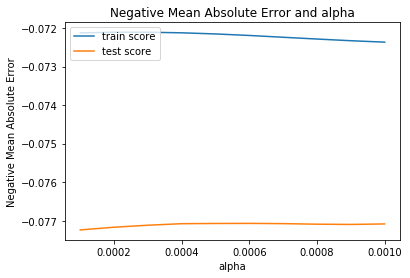

In [964]:
# plotting mean test and train scoes with alpha 
cv_results['param_alpha'] = cv_results['param_alpha'].astype('float32')

# plotting
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')

plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper left')
plt.show()

In [965]:
#Small hump is seen near 0.0004, thus picking this value
alpha =0.0004

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train_rfe, y_train) 

Lasso(alpha=0.0004, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [966]:
lasso.coef_

array([ 2.16670583e-02,  7.48642480e-02,  5.72158424e-02,  2.06042954e-02,
        5.11180011e-02,  0.00000000e+00,  1.35678452e-02, -4.84984404e-03,
        1.20170492e-01,  1.61764554e-02, -9.34227479e-03,  1.98997657e-02,
        1.82934180e-02,  8.92091593e-03, -8.18652216e-02, -9.28165054e-03,
        8.58142779e-03, -8.13745951e-03, -1.44912314e-02, -1.12873761e-02,
        1.18950643e-02, -9.93181064e-03,  1.77457198e-02, -8.60068532e-03,
       -9.73380300e-03, -1.66849882e-02, -9.14569047e-03,  1.23884748e-02,
       -1.00619797e-02,  1.68362997e-02,  9.72420956e-03,  1.26028522e-02,
       -1.05924687e-02, -1.58017540e-02, -1.18153698e-02,  2.19502433e-02,
       -1.80534551e-02,  8.43234695e-03,  1.26964003e-02,  8.35592157e-03,
       -2.06219651e-02, -1.02262459e-05, -9.34170289e-03, -3.48362708e-03,
        1.84308367e-02,  1.10672996e-02, -4.62207643e-05, -0.00000000e+00,
        7.39829339e-03, -1.63205989e-02])

In [967]:
pd.Series(lasso.coef_, index = X_train_rfe.columns).sort_values(ascending=False)

GrLivArea                     0.120170
OverallQual                   0.074864
OverallCond                   0.057216
TotalBsmtSF                   0.051118
Foundation_PConc              0.021950
LotArea                       0.021667
BsmtFinSF1                    0.020604
GarageCars                    0.019900
BsmtCond_TA                   0.018431
GarageArea                    0.018293
Neighborhood_Crawfor          0.017746
Neighborhood_Somerst          0.016836
BsmtFullBath                  0.016176
2ndFlrSF                      0.013568
Exterior1st_Others            0.012696
Condition1_Norm               0.012603
Neighborhood_NridgHt          0.012388
MSZoning_RL                   0.011895
BsmtExposure_Gd               0.011067
Neighborhood_StoneBr          0.009724
ScreenPorch                   0.008921
MSSubClass_1StryPUD           0.008581
Exterior1st_MetalSd           0.008432
Exterior1st_VinylSd           0.008356
FireplaceQu_Gd                0.007398
1stFlrSF                 

In [968]:
pd.Series(lasso.coef_, index = X_train_rfe.columns).sort_values(ascending=False).head(15)
#Below mentioned 15 features are having the most influence on SalePrice in positive manner

GrLivArea               0.120170
OverallQual             0.074864
OverallCond             0.057216
TotalBsmtSF             0.051118
Foundation_PConc        0.021950
LotArea                 0.021667
BsmtFinSF1              0.020604
GarageCars              0.019900
BsmtCond_TA             0.018431
GarageArea              0.018293
Neighborhood_Crawfor    0.017746
Neighborhood_Somerst    0.016836
BsmtFullBath            0.016176
2ndFlrSF                0.013568
Exterior1st_Others      0.012696
dtype: float64

In [969]:
pd.Series(np.absolute(lasso.coef_), index = X_train_rfe.columns).sort_values(ascending=False).head(15)
#I believe -ve factors also should be considered and these are -vely correlated and have a big impact on SalePrice
#Below table shows the absolute value of top 15 factors


GrLivArea               0.120170
buildingAge             0.081865
OverallQual             0.074864
OverallCond             0.057216
TotalBsmtSF             0.051118
Foundation_PConc        0.021950
LotArea                 0.021667
BsmtQual_Gd             0.020622
BsmtFinSF1              0.020604
GarageCars              0.019900
BsmtCond_TA             0.018431
GarageArea              0.018293
HouseStyle_1Story       0.018053
Neighborhood_Crawfor    0.017746
Neighborhood_Somerst    0.016836
dtype: float64

In [970]:
# predict
y_train_pred = lasso.predict(X_train_rfe)
print("Lasso Train Score : ", r2_score(y_true=y_train, y_pred=y_train_pred))
y_test_pred = lasso.predict(X_test_rfe)
print("Lasso Test Score : ", r2_score(y_true=y_test, y_pred=y_test_pred))

Lasso Train Score :  0.9262685704856588
Lasso Test Score :  0.8796840444940227


Lasso Regression - Lambda is taken as 0.0004

GrLivArea               0.120170
buildingAge (-ve)             0.081865
OverallQual             0.074864
OverallCond             0.057216
TotalBsmtSF             0.051118
Foundation_PConc        0.021950
LotArea                 0.021667
BsmtQual_Gd(-ve)         0.020622
BsmtFinSF1              0.020604
GarageCars              0.019900
BsmtCond_TA             0.018431
GarageArea              0.018293
HouseStyle_1Story  (-ve)     0.018053
Neighborhood_Crawfor    0.017746
Neighborhood_Somerst    0.016836

##### Regularization - Ridge

In [971]:
# list of alphas to tune
params = {'alpha': [ 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}
# cross validation
folds = 5

In [972]:
ridge = Ridge()

model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train_rfe, y_train) 

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:    0.3s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=1)

In [973]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results = cv_results[cv_results['param_alpha']<=200]
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.003598,0.001356,0.000800,7.481371e-04,1,{'alpha': 1.0},-0.079403,-0.075300,-0.077884,-0.075492,...,-0.077279,0.001617,13,-0.072277,-0.072706,-0.071431,-0.072512,-0.071842,-0.072154,0.000462
1,0.003401,0.000487,0.001596,4.873563e-04,2,{'alpha': 2.0},-0.079365,-0.075289,-0.077859,-0.075396,...,-0.077238,0.001625,12,-0.072264,-0.072706,-0.071432,-0.072501,-0.071827,-0.072146,0.000462
2,0.003198,0.000748,0.000999,5.436780e-07,3,{'alpha': 3.0},-0.079327,-0.075280,-0.077836,-0.075303,...,-0.077199,0.001633,10,-0.072252,-0.072705,-0.071435,-0.072491,-0.071814,-0.072139,0.000460
3,0.002199,0.000400,0.001010,6.329574e-04,4,{'alpha': 4.0},-0.079293,-0.075272,-0.077813,-0.075219,...,-0.077164,0.001641,9,-0.072243,-0.072705,-0.071443,-0.072482,-0.071803,-0.072135,0.000457
4,0.002599,0.000490,0.000799,3.996850e-04,5,{'alpha': 5.0},-0.079259,-0.075265,-0.077799,-0.075139,...,-0.077133,0.001648,8,-0.072237,-0.072705,-0.071452,-0.072473,-0.071794,-0.072132,0.000454


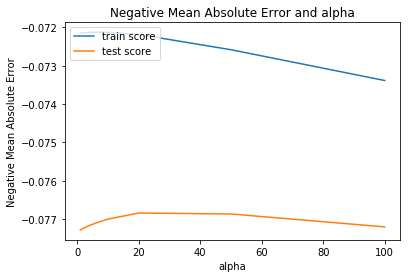

In [974]:
# plotting mean test and train scoes with alpha 
cv_results['param_alpha'] = cv_results['param_alpha'].astype('int32')

# plotting
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')
plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper left')
plt.show()

In [975]:
alpha = 20
ridge = Ridge(alpha=alpha)

ridge.fit(X_train_rfe, y_train)
ridge.coef_

array([ 0.02178045,  0.07317095,  0.05453122,  0.01998519,  0.05086585,
        0.03461612,  0.05205554, -0.00104405,  0.07255047,  0.01577036,
       -0.00972291,  0.02077254,  0.01896384,  0.00891366, -0.07308993,
       -0.01235579,  0.00880609, -0.01152784, -0.01552401, -0.01518098,
        0.01202724, -0.00953203,  0.01744436, -0.00939152, -0.01099882,
       -0.01683092, -0.00938474,  0.01263547, -0.01144373,  0.01764319,
        0.01041534,  0.01303956, -0.00961286, -0.01579319, -0.01227636,
        0.0227467 , -0.0229983 ,  0.00921408,  0.01361186,  0.00981657,
       -0.02291369, -0.00236905, -0.01334276, -0.00236905,  0.01660152,
        0.01123793, -0.00236905, -0.00236905,  0.00764812, -0.01698966])

In [976]:
pd.Series(ridge.coef_, index = X_train_rfe.columns).sort_values(ascending=False)

OverallQual                   0.073171
GrLivArea                     0.072550
OverallCond                   0.054531
2ndFlrSF                      0.052056
TotalBsmtSF                   0.050866
1stFlrSF                      0.034616
Foundation_PConc              0.022747
LotArea                       0.021780
GarageCars                    0.020773
BsmtFinSF1                    0.019985
GarageArea                    0.018964
Neighborhood_Somerst          0.017643
Neighborhood_Crawfor          0.017444
BsmtCond_TA                   0.016602
BsmtFullBath                  0.015770
Exterior1st_Others            0.013612
Condition1_Norm               0.013040
Neighborhood_NridgHt          0.012635
MSZoning_RL                   0.012027
BsmtExposure_Gd               0.011238
Neighborhood_StoneBr          0.010415
Exterior1st_VinylSd           0.009817
Exterior1st_MetalSd           0.009214
ScreenPorch                   0.008914
MSSubClass_1StryPUD           0.008806
FireplaceQu_Gd           

In [977]:
pd.Series(np.absolute(ridge.coef_), index = X_train_rfe.columns).sort_values(ascending=False)

OverallQual                   0.073171
buildingAge                   0.073090
GrLivArea                     0.072550
OverallCond                   0.054531
2ndFlrSF                      0.052056
TotalBsmtSF                   0.050866
1stFlrSF                      0.034616
HouseStyle_1Story             0.022998
BsmtQual_Gd                   0.022914
Foundation_PConc              0.022747
LotArea                       0.021780
GarageCars                    0.020773
BsmtFinSF1                    0.019985
GarageArea                    0.018964
Neighborhood_Somerst          0.017643
Neighborhood_Crawfor          0.017444
FireplaceQu_NA                0.016990
Neighborhood_MeadowV          0.016831
BsmtCond_TA                   0.016602
BldgType_Others               0.015793
BsmtFullBath                  0.015770
MSSubClass_2StryNewer         0.015524
MSSubClass_Others             0.015181
Exterior1st_Others            0.013612
BsmtQual_TA                   0.013343
Condition1_Norm          

In [978]:
#Below mentioned 15 features are having the most influence on SalePrice in positive manner
pd.Series(ridge.coef_, index = X_train_rfe.columns).sort_values(ascending=False).head(15)

OverallQual             0.073171
GrLivArea               0.072550
OverallCond             0.054531
2ndFlrSF                0.052056
TotalBsmtSF             0.050866
1stFlrSF                0.034616
Foundation_PConc        0.022747
LotArea                 0.021780
GarageCars              0.020773
BsmtFinSF1              0.019985
GarageArea              0.018964
Neighborhood_Somerst    0.017643
Neighborhood_Crawfor    0.017444
BsmtCond_TA             0.016602
BsmtFullBath            0.015770
dtype: float64

In [979]:
#I believe -ve factors also should be considered and these are -vely correlated and have a big impact on SalePrice
#Below table shows the absolute value of top 15 factors
pd.Series(np.absolute(ridge.coef_), index = X_train_rfe.columns).sort_values(ascending=False).head(15)

OverallQual             0.073171
buildingAge             0.073090
GrLivArea               0.072550
OverallCond             0.054531
2ndFlrSF                0.052056
TotalBsmtSF             0.050866
1stFlrSF                0.034616
HouseStyle_1Story       0.022998
BsmtQual_Gd             0.022914
Foundation_PConc        0.022747
LotArea                 0.021780
GarageCars              0.020773
BsmtFinSF1              0.019985
GarageArea              0.018964
Neighborhood_Somerst    0.017643
dtype: float64

Ridge Regression - Lambda is taken as 20

OverallQual             0.073171
buildingAge (-ve)         0.073090
GrLivArea               0.072550
OverallCond             0.054531
2ndFlrSF                0.052056
TotalBsmtSF             0.050866
1stFlrSF                0.034616
HouseStyle_1Story (-ve)      0.022998
BsmtQual_Gd (-ve)            0.022914
Foundation_PConc        0.022747
LotArea                 0.021780
GarageCars              0.020773
BsmtFinSF1              0.019985
GarageArea              0.018964
Neighborhood_Somerst    0.017643

In [980]:
# predict
y_train_pred = ridge.predict(X_train_rfe)
print("Ridge train score : ", r2_score(y_true=y_train, y_pred=y_train_pred))
y_test_pred = ridge.predict(X_test_rfe)
print("Ridge test score : ", r2_score(y_true=y_test, y_pred=y_test_pred))

Ridge train score :  0.9262318071295061
Ridge test score :  0.8806007901047123
